# Lung fibrosis v4 - ResNet34

This notebook uses the [dataset](https://osf.io/28qbc/) from the publication "[Deep neural network based histological scoring of lung fibrosis and inflammation in the mouse model system](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0202708)" to train an CNN based on a ResNet34 to characterize lung fibrosis from sections of lung tissue.<br><br>

**Publication benchmark:**<br>
Model: Inception V3, pretrained on ImageNet<br>
Accuracy: 0.795 (79.5%).<br><br>


<font color='blue'>**Notebook results:**<br>
Model: ResNet34, pretrained on ImageNet<br>
Data: training and validation data were used as in the provided dataset<br>
Training: image size of 224 for stage 1 and 2, image size of 512 for stage 3;<br>
stage 1: training of new network head;<br>
stage 2: training of the entire network with discriminative learning rates;<br>
stage 3: training of the entire network<br>
Accuracy: 0.803 (80,3%).<br><br>
    
**Summary:**<br>In this notebook it could be shown that state-of-the-art results published August 23 2018 could be  improved with a smaller model.

## Notebook setup

In [1]:
## notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai
from fastai import *
from fastai.vision import *

In [3]:
# set path
path = Path('/home/paperspace/fastai/data/lung'); path

PosixPath('/home/paperspace/fastai/data/lung')

## Setup data and model (stage 1 and 2)

### Data setup

In [4]:
# set batchsize and image size for network
#bs = 256
bs = 200
size = 224

In [5]:
# different transformations (the increase of the max_rotate parameter is crucial to improve the performance)
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0, max_warp=0.2) #1
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=1.1, max_lighting=0.1, max_warp=0.2) #2
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=1.1, max_lighting=0.2, max_warp=0.2) #3

In [6]:
# setup data with fastai data block API (https://docs.fast.ai/data_block.html)
data = (ImageFileList.from_folder(path/'lung_fibrosis', extensions='.png')\
        .label_from_folder() # get labels from folders\
        .split_by_folder() # split dataset by train/valid folders\
        .datasets(ImageClassificationDataset) # creat image classification dataset\
        .transform(tfms, size=size) # apply transformations and resize images\
        .databunch(bs=bs)) # creat databunch with bs

In [7]:
# normaliez data with ImagNet statistics
data.normalize(imagenet_stats);

In [8]:
# print class names, number of class, length of train dataset, and length of valid dataset
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '3', 'ignore', '5', '7', '1'], 6, 12037, 2139)

### Model setup

A ResNet34 is setup with pretrained weights from Imagenet with a custom head, i.e. the final layers specific for ImageNet classification are removed and replaced by final layers suitable for our 5 classes.

In [9]:
!gpustat --no-header

[0] Quadro P4000     | 30'C,   0 % |  6885 /  8119 MB | paperspace(6875M)


In [10]:
# create learner for mixed precision training, from https://docs.fast.ai/callbacks.fp16.html
learn = create_cnn(data, models.resnet34, metrics=accuracy).to_fp16()

In [11]:
# add save SaveModelCallback to save the model weights for every epoch
learn.callback_fns.append(partial(SaveModelCallback, every='epoch', name='lung_fib_v4-ResNet34_stage-X_train-Y_epoch'))

In [12]:
#learn.callback_fns.append(partial(ReduceLROnPlateauCallback, patience=0, factor=0.2, min_delta=0))

In [13]:
learn.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lung_fib_v4-ResNet34_stage-X_train-Y_epoch')]

In [14]:
!gpustat --no-header

[0] Quadro P4000     | 31'C,   0 % |  7474 /  8119 MB | paperspace(6875M) paperspace(589M)


## Training (stage 1 and 2)

### Stage 1 - Training of new head

In stage 1 only the new head of the network is trained and rest is frozen.

In [ ]:
# loss vs learning rate vs batch size see: https://miguel-data-sc.github.io/2017-11-05-first/

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


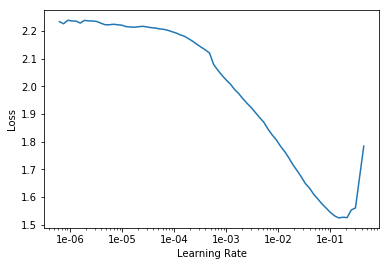

In [15]:
# find learning rate at the highest negative slope at the loss vs. learning rate plot
learn.lr_find()
learn.recorder.plot()

In [16]:
!gpustat --no-header

[0] Quadro P4000     | 49'C,   0 % |  5153 /  8119 MB | paperspace(5143M)


In [21]:
# find optimal weight decay parameter
# from https://github.com/DrHB/fastai_wd/blob/master/wd_example.ipynb

@dataclass  
class wd_finder:
    #learner
    #wd, can be a single value or a tuple
    # if no wd is passed it will use standard wds 
    
    learn: Learner
    wd:Union[int,Callable]=None
    
    def __post_init__(self, **kwargs):
        self.wd_list = listify(self.wd)
        self.wd_recorder = []
        
        if self.wd is None:
            self.wd_list = [0, 1e-1, 1e-3, 1e-5]
            
        for wd in self.wd_list:
            self.learn.lr_find(wd=self.wd, **kwargs)
            self.wd_recorder.append(self.learn.recorder)
            
    def plot_wd(self, skip_start:int=10, skip_end:int=5)->None:
        _, ax = plt.subplots(1,1)
        
        for k, i in enumerate(self.wd_recorder):
            losses = i.losses[skip_start:-skip_end] if skip_end > 0 else i.losses[skip_start:]
            lrs = i.lrs[skip_start:-skip_end] if skip_end > 0 else i.lrs[skip_start:]
            ax.plot(lrs, losses, label='wd = {}'.format(self.wd_list[k]))
            ax.legend()
            ax.set_xscale('log')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


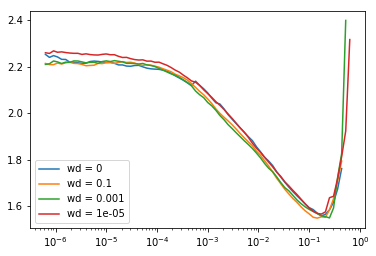

In [18]:
find_wd = wd_finder(learn)
find_wd.plot_wd()

In [19]:
wd = 0.1

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


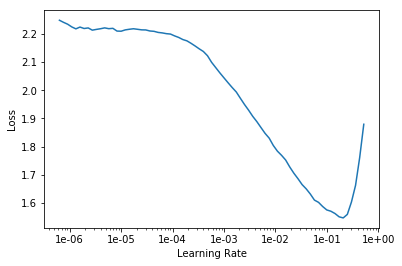

In [20]:
# verify selected weight decay parameter
learn.lr_find(wd=wd)
learn.recorder.plot()

In [25]:
lr = 1e-2

In [26]:
# check learning rate and weight decay parameter
lr, wd

(0.01, 0.1)

In [27]:
learn.fit_one_cycle(12, max_lr=lr, wd=wd)

Total time: 14:19
epoch  train_loss  valid_loss  accuracy
1      1.151312    0.777836    0.696120  (01:11)
2      0.848589    0.611139    0.741935  (01:11)
3      0.732959    0.912047    0.673679  (01:09)
4      0.708233    0.639988    0.717625  (01:09)
5      0.687237    0.742263    0.687237  (01:11)
6      0.660377    0.555474    0.769051  (01:10)
7      0.606963    0.813058    0.689575  (01:11)
8      0.611301    0.747456    0.659654  (01:12)
9      0.647092    0.517409    0.785414  (01:13)
10     0.596826    0.517173    0.777466  (01:12)
11     0.567325    0.498768    0.788686  (01:12)
12     0.545044    0.489665    0.792894  (01:12)



In [15]:
# load weights from epoch 11 with an accuracy of 0.826446
learn.load('lung_fib_v4-ResNet34_stage-1_train-1_epoch-12_0-792894')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


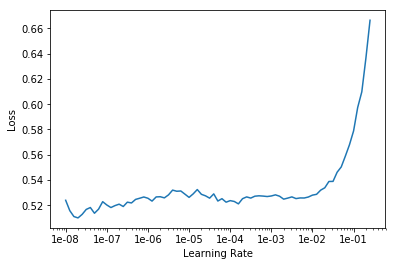

In [30]:
# verify learning rate parameter
learn.lr_find(start_lr=1e-9)
learn.recorder.plot()

In [16]:
lr = 1e-3
wd = 0.1 # from above

In [17]:
learn.fit_one_cycle(6, max_lr=lr, wd=wd)

Total time: 07:16
epoch  train_loss  valid_loss  accuracy
1      0.562494    0.488099    0.797101  (01:15)
2      0.604984    0.512922    0.784479  (01:11)
3      0.539828    0.507990    0.788686  (01:11)
4      0.543737    0.485593    0.799906  (01:12)
5      0.553025    0.483291    0.792894  (01:12)
6      0.529059    0.489777    0.800842  (01:13)



In [20]:
learn.load('lung_fib_v4-ResNet34_stage-1_train-2_epoch-6_0-800842')

<font color=blue>**Conclusion stage 1 - Training of new head:**<br>
Training only the the new last layers from the new head (and keeping the rest of the network frozen) enabled the network to achieve a accuracy of approx. 0.83 (83%) after 18 epochs. This already improved the published accuracy benchmark!

### Stage 2 - Training of the entire network

In stage 2 the entire network is trained with discriminative learning rates, i.e. lower learning rates for the earyl layers and higher learning rates for the late layers.

In [15]:
!gpustat --no-header

[0] Quadro P4000     | 36'C,   0 % |   599 /  8119 MB | paperspace(589M)


In [16]:
learn.load('lung_fib_v4-ResNet34_stage-1_train-2_epoch-6_0-800842')

In [17]:
# reduce learning rate callback when hitting plateau
#learn.callback_fns.append(partial(ReduceLROnPlateauCallback, patience=0, factor=0.2, min_delta=0)) # CAUSES ERROR?

In [18]:
learn.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lung_fib_v4-ResNet34_stage-X_train-Y_epoch')]

In [19]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


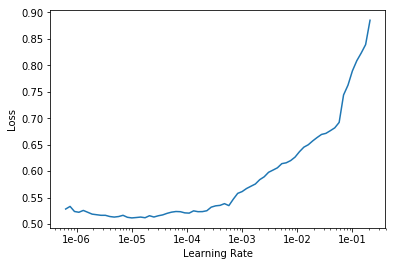

In [19]:
learn.lr_find()
learn.recorder.plot()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


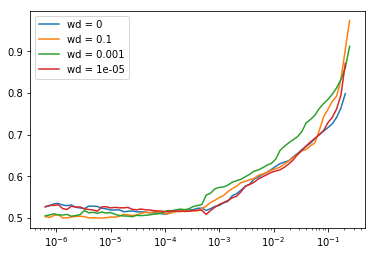

In [22]:
find_wd = wd_finder(learn)
find_wd.plot_wd()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


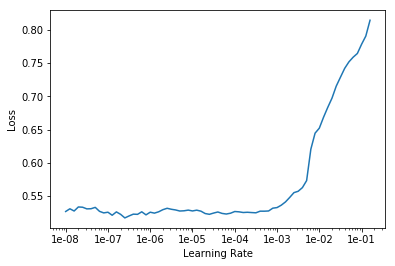

In [20]:
learn.lr_find(start_lr=1e-9)
learn.recorder.plot()

In [22]:
max_lr = 1e-5
wd = 1e-5

In [23]:
!gpustat --no-header

[0] Quadro P4000     | 30'C,   0 % |  5007 /  8119 MB | paperspace(4997M)


In [24]:
learn.fit_one_cycle(12, max_lr=slice(1e-8, max_lr))

Total time: 16:54
epoch  train_loss  valid_loss  accuracy
1      0.519769    0.484284    0.799439  (01:25)
2      0.521147    0.477579    0.803179  (01:24)
3      0.513666    0.480912    0.802712  (01:24)
4      0.514928    0.477805    0.801777  (01:25)
5      0.516942    0.479073    0.800842  (01:24)
6      0.512857    0.481133    0.803179  (01:25)
7      0.516579    0.480175    0.798971  (01:23)
8      0.516822    0.483941    0.799439  (01:23)
9      0.521936    0.482071    0.803179  (01:24)
10     0.521392    0.489312    0.799906  (01:23)
11     0.516497    0.479659    0.800842  (01:24)
12     0.515332    0.477043    0.801309  (01:24)



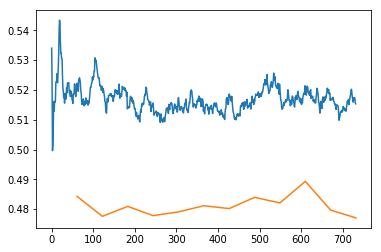

In [25]:
learn.recorder.plot_losses()

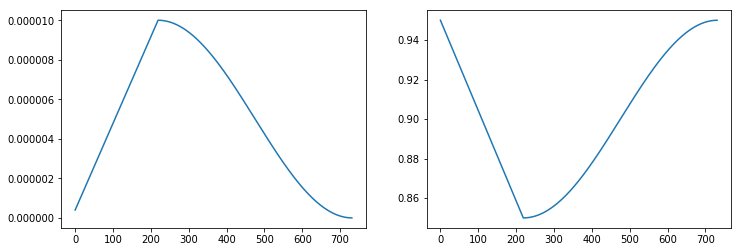

In [26]:
learn.recorder.plot_lr(show_moms=True)

### Predictions

In [8]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [9]:
learn.load('lung_fib_v4-ResNet34_stage-2_train-3_epoch-2_0-803179')

In [10]:
learn.get_preds()

[tensor([[9.9520e-01, 8.4647e-05, 6.4319e-04, 1.2293e-05, 1.1649e-04, 3.9448e-03],
         [9.6948e-01, 1.9020e-03, 7.4526e-03, 1.7938e-04, 2.7536e-04, 2.0709e-02],
         [9.5564e-01, 2.2896e-03, 8.0905e-03, 1.4795e-04, 1.7795e-04, 3.3650e-02],
         ...,
         [4.7745e-03, 2.0236e-01, 3.1433e-04, 9.4166e-04, 8.3525e-06, 7.9160e-01],
         [1.0212e-01, 2.6908e-02, 7.8611e-01, 9.6888e-03, 2.9770e-03, 7.2190e-02],
         [3.5973e-01, 1.4563e-02, 9.8376e-04, 3.5523e-04, 1.9990e-04, 6.2416e-01]]),
 tensor([0, 0, 0,  ..., 5, 5, 5])]

In [11]:
# check validation set loss and accuracy
#learn.validate(data.valid_dl.add_tfm(to_half)) # mixed precision WORKS!
learn.validate()

[0.47767818, tensor(0.8036)]

In [12]:
#learn.TTA(data.valid_dl.add_tfm(to_half)) # mixed precision DOES NOT WORK
learn.TTA()

Total time: 01:53



(tensor([[0.9831, 0.0004, 0.0010, 0.0000, 0.0001, 0.0154],
         [0.8531, 0.0109, 0.0432, 0.0006, 0.0003, 0.0919],
         [0.6324, 0.0246, 0.0238, 0.0006, 0.0002, 0.3183],
         ...,
         [0.0094, 0.2813, 0.0016, 0.0025, 0.0000, 0.7051],
         [0.1047, 0.0887, 0.6216, 0.0176, 0.0032, 0.1641],
         [0.2114, 0.0752, 0.0025, 0.0015, 0.0002, 0.7092]]),
 tensor([0, 0, 0,  ..., 5, 5, 5]))

<font color=blue>**Conclusion stage 2 - Training of the entire network:**<br>
The training of the entire network with discriminative learning rates was able to reduce the training loss and increase the accuracy slightly.

## Interpretation

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

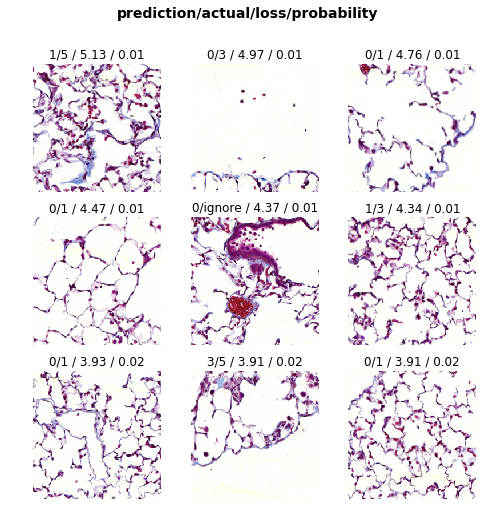

In [14]:
interp.plot_top_losses(9, figsize=(8,8))

In [15]:
interp.confusion_matrix()

array([[829,   0,   9,   0,   0,  49],
       [  4, 176,  14,  24,   0,  74],
       [ 24,   4, 229,   3,   1,   6],
       [  0,  29,   9, 120,  10,   2],
       [  0,   0,   1,  21,  43,   0],
       [ 86,  45,   5,   0,   0, 322]])

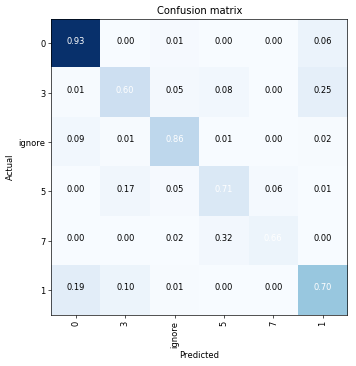

In [16]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60, normalize=True)